# Autocorrelation Analyses

# Load Modules

In [179]:
%matplotlib inline

import warnings
from copy import deepcopy
import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltools.stats import (threshold, 
                           align,
                           fdr, 
                           isc,
                           _calc_pvalue,
                           regress,
                           one_sample_permutation)
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain

from fnl_tools.stats import (exponential_func,
                            calculate_spatial_temporal_correlation,
                            fit_exponential_function,
                            time_to_correlation,
                            autocorrelation)
from nilearn.plotting import plot_glass_brain

from sklearn.utils import check_random_state
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr
from scipy.optimize import curve_fit

warnings.filterwarnings('ignore')

# base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'
base_dir = '/Volumes/Engram/Data/vmpfc/'



# Spatial Autocorrelation
## Fit curve to spatial autocorrelation function to each subject

In [72]:
roi = 32
study = 'Study1'
episode = 'ep01'

for study in ['Study1', 'Study2']:
    for roi in tqdm(range(50)):
        file_list = glob.glob(os.path.join(base_dir, 'Data', study, 'Denoised_ROI', f'*{episode}_Denoised_ROI{roi}.csv'))

        auto_corr = calculate_spatial_temporal_correlation(file_list)
        auto_corr.to_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ROI{roi}.csv'))

        params = fit_exponential_function(auto_corr)
        params.to_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ExpFunc_Params_ROI{roi}.csv'))


100%|██████████| 50/50 [1:47:43<00:00, 129.26s/it]  


## Fit curve to median of all subjects

In [175]:
for study in ['Study1', 'Study2']:
    params = {}
    for roi in range(50):
        r = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ROI{roi}.csv'), index_col=0)
        r.drop(columns='Lag', inplace=True)
        lag = np.arange(0,49)

        popt, pcov = curve_fit(exponential_func, lag, r.median(axis=1), maxfev=3000)
        params[roi] = np.concatenate([popt, np.sqrt(np.diag(pcov))])
    params = pd.DataFrame(params,index=['a','b','c','a_sd','b_sd','c_sd']).T
    params['ROI'] = params.index
    params.to_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ExpFunc_Params_Median_ROI.csv'))


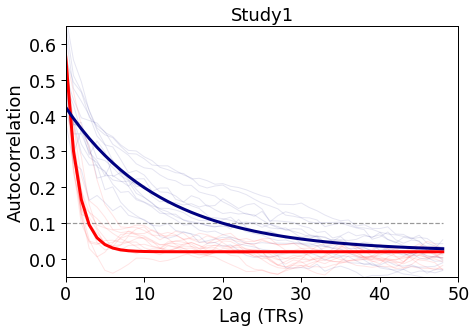

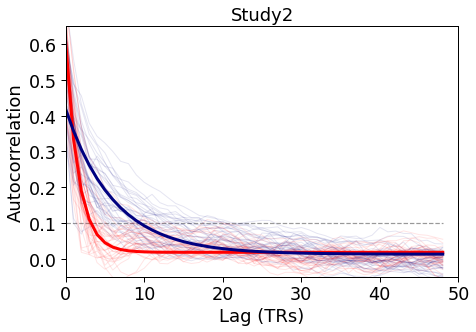

In [12]:
colors = ['red','navy']
for study in ['Study1', 'Study2']:
    with sns.plotting_context(context='paper',font_scale=2):
        f,a = plt.subplots(ncols=1,figsize=(7,5))
        for i,roi in enumerate([4,32]):
            r = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ROI{roi}.csv'),index_col=0)
            lag = r['Lag']
            r.drop(columns='Lag', inplace=True)
            for sub in r: # raw
                a.plot(lag, r[sub], color=colors[i], linewidth=1,alpha=.1,linestyle='-')
        params = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ExpFunc_Params_Median_ROI.csv'), index_col=0)
        for i,roi in enumerate([4,32]):
            a.plot(lag, exponential_func(lag, 
                                     params.query('ROI==@roi')['a'].values[0],
                                     params.query('ROI==@roi')['b'].values[0],
                                     params.query('ROI==@roi')['c'].values[0]), color=colors[i],linewidth=3)
        a.set_xlabel('Lag (TRs)', fontsize=18)
        a.set_ylabel('Autocorrelation', fontsize=18)
        plt.hlines(.1,xmin=0,xmax=r.shape[0]-1,linestyle='--',color='grey',alpha=.8)
        a.set_xlim([0,50])
        a.set_ylim([-0.05,.65])
        a.set_title(f'{study}', fontsize=18)
        plt.tight_layout()
        plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation',f'SpatialPattern_Autocorrelation_Figure_{study}.pdf'))
        plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation',f'SpatialPattern_Autocorrelation_Figure_{study}.png'), dpi=300)


## Autocorrelation timescale - time to r=0.1

Study1 TRs: 3, 20
Study2 TRs: 4, 10


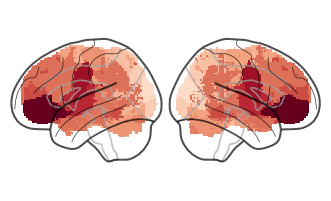

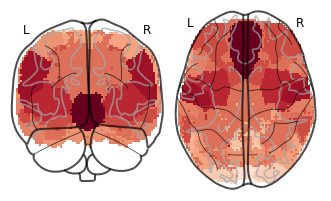

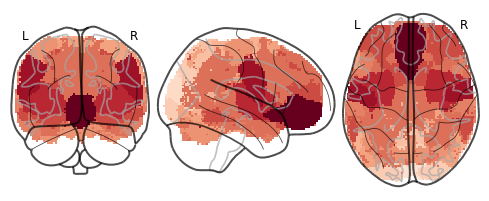

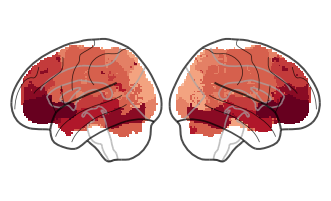

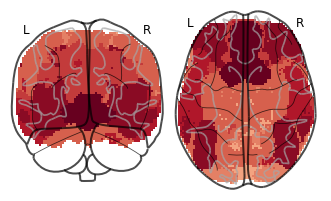

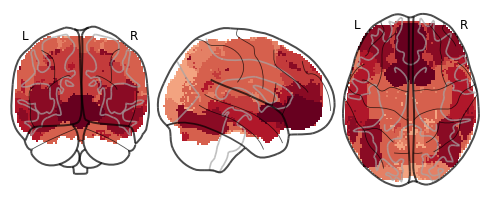

In [3]:
mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

max_time = {'Study1':20, 'Study2':10}

for study in ['Study1', 'Study2']:
    params = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ExpFunc_Params_Median_ROI.csv'), index_col=0)
    out = time_to_correlation(params, correlation=.1, lags=50)
    dat = roi_to_brain(out, mask_x)

    cmap = 'RdBu_r'
#     max_time = out.max()

    plot_glass_brain(dat.to_nifti(), display_mode='lr', colorbar=False, cmap=cmap, plot_abs=False,vmin=0, vmax=max_time[study])
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Spatial_Autocorrelation_Brain_Lateral_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Spatial_Autocorrelation_Brain_Lateral_Figure.png'), dpi=300)

    plot_glass_brain(dat.to_nifti(), display_mode='yz', colorbar=False, cmap=cmap, plot_abs=False,vmin=0, vmax=max_time[study])
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Spatial_Autocorrelation_Brain_Medial_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Spatial_Autocorrelation_Brain_Medial_Figure.png'), dpi=300)

    plot_glass_brain(dat.to_nifti(), display_mode='ortho', colorbar=False, cmap=cmap, plot_abs=False, vmin=0, vmax=max_time[study])
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Spatial_Autocorrelation_Brain_Ortho_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Spatial_Autocorrelation_Brain_Ortho_Figure.png'), dpi=300)

    print(f'{study} TRs: {out[4]}, {out[32]}')
    

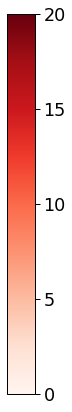

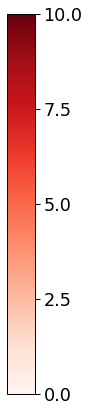

In [129]:
for study in ['Study1', 'Study2']:
    with sns.plotting_context(context='paper', font_scale=2):
        fig, ax = plt.subplots(figsize=(0.5, 6))
        fig.subplots_adjust(bottom=0)

        cmap = mpl.cm.Reds
        norm = mpl.colors.Normalize(vmin=0, vmax=max_time[study])
        cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical', ticks=np.linspace(0, max_time[study], 5))
        plt.tight_layout()
        plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Spatial_Autocorrelation_Colorbar_Vertical.pdf'))


## Test for significant Differences between ROIs on time to 0.1 correlation

In [214]:
for study in ['Study1', 'Study2']:
    for roi in [4, 32]:
        r = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ROI{roi}.csv'), index_col=0)
        r.drop(columns='Lag', inplace=True)
        lag = np.arange(0,49)
        sub_params = {}
        for sub in r.columns:
            popt, pcov = curve_fit(exponential_func, lag, r[sub], maxfev=3000)
            sub_params[sub] = np.concatenate([popt, np.sqrt(np.diag(pcov))])
        roi_params = pd.DataFrame(sub_params, index=['a','b','c','a_sd','b_sd','c_sd']).T
        roi_params.to_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ExpFunc_Params_Subject_ROI{roi}.csv'))

for study in ['Study1', 'Study2']:
    out = {}
    for roi in [4,32]:
        dat = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ExpFunc_Params_Subject_ROI{roi}.csv'), index_col=0)
        dat['Subject'] = dat.index
        out[roi] = time_to_correlation(dat, id_column='Subject')
    out = pd.DataFrame(out)
    print(f'\n{study}')
    print(out.describe())
    stats = one_sample_permutation(out[32] - out[4])
    print(f"p = {stats['p']}")



Study1
             4          32
count  13.00000  13.000000
mean    4.00000  21.692308
std     1.47196   8.004005
min     3.00000  11.000000
25%     3.00000  16.000000
50%     3.00000  21.000000
75%     5.00000  26.000000
max     8.00000  37.000000
p = 0.0005998800239952009

Study2
              4          32
count  35.000000  35.000000
mean    4.057143  10.571429
std     1.625945   4.125143
min     2.000000   3.000000
25%     3.000000   7.000000
50%     4.000000  11.000000
75%     4.500000  13.000000
max    10.000000  20.000000
p = 0.0001999600079984003


# Voxel Autocorrelation
## Estimate autocorrelation for each voxel

In [265]:
episode = 'ep01'
delay = 50

for study in ['Study1', 'Study2']:
    for roi in tqdm(range(50)):
        file_list = glob.glob(os.path.join(base_dir, 'Data', study, 'Denoised_ROI', f'*{episode}_Denoised_ROI{roi}.csv'))
        autocorr_all = {}
        for f in file_list:
            sub = os.path.basename(f).split('_')[0]
            data = pd.read_csv(f)
            dat = pd.DataFrame(data.apply(autocorrelation, delay=delay, axis=0))
            dat.to_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_{sub}_Voxel_Autocorrelation_ROI{roi}_delay{delay}.csv'))
            autocorr_all[sub] = dat.median(axis=1)
        autocorr_all = pd.DataFrame(autocorr_all)
        autocorr_all.to_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_median.csv'))


100%|██████████| 50/50 [4:20:20<00:00, 312.41s/it]  


## Compute mean across voxels within ROI

In [42]:
delay = 50
for study in ['Study1', 'Study2']:
    for roi in tqdm(range(50)):
        file_list = glob.glob(os.path.join(base_dir, 'Analyses', 'Autocorrelation_Voxel', f'{study}_*_Voxel_Autocorrelation_ROI{roi}_delay{delay}.csv'))
        autocorr_all = {}
        for f in file_list:
            sub = os.path.basename(f).split('_')[1]
            dat = pd.read_csv(f, index_col=0)
            autocorr_all[sub] = dat.mean(axis=1)
        autocorr_all = pd.DataFrame(autocorr_all)
        autocorr_all.to_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_mean.csv'))


100%|██████████| 50/50 [06:10<00:00,  7.41s/it]


## Fit curve to median of all subjects

In [44]:
lag = np.arange(0,50)
for metric in ['mean','median']:
    for study in ['Study1', 'Study2']:
        params = {}
        for roi in tqdm(range(50)):
            autocorr_all = pd.read_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_{metric}.csv'), index_col=0)
            popt, pcov = curve_fit(exponential_func, lag, autocorr_all.median(axis=1), maxfev=3000)
            params[roi] = np.concatenate([popt, np.sqrt(np.diag(pcov))])
        params = pd.DataFrame(params,index=['a','b','c','a_sd','b_sd','c_sd']).T
        params['ROI'] = params.index
        params.to_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Voxel', f'{study}_Autocorrelation_Voxel_ExpFunc_Params_{metric}_ROI.csv'))


100%|██████████| 50/50 [00:00<00:00, 69.84it/s]


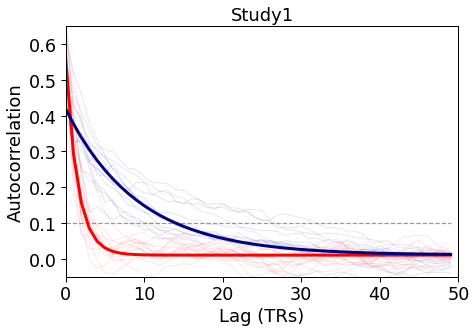

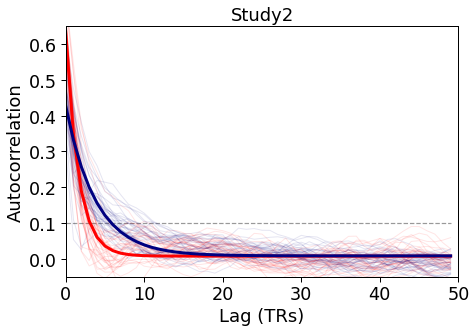

In [14]:
metric='median'
lag = np.arange(0,50)
delay=50

colors = ['red', 'navy']
for study in ['Study1', 'Study2']:
    with sns.plotting_context(context='paper', font_scale=2):
        f,a = plt.subplots(ncols=1,figsize=(7,5))
        for i,roi in enumerate([4,32]):
            r = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_{metric}.csv'), index_col=0)
            for sub in r: # raw
                a.plot(lag, r[sub], color=colors[i], linewidth=1,alpha=.1,linestyle='-')
        params = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Voxel', f'{study}_Autocorrelation_Voxel_ExpFunc_Params_{metric}_ROI.csv'), index_col=0)
        for i,roi in enumerate([4,32]):
            a.plot(lag, exponential_func(lag, 
                                     params.query('ROI==@roi')['a'].values[0],
                                     params.query('ROI==@roi')['b'].values[0],
                                     params.query('ROI==@roi')['c'].values[0]), color=colors[i],linewidth=3)
        a.set_xlabel('Lag (TRs)', fontsize=18)
        a.set_ylabel('Autocorrelation', fontsize=18)
        plt.hlines(.1,xmin=0,xmax=r.shape[0]-1,linestyle='--',color='grey',alpha=.8)
        a.set_xlim([0,50])
        a.set_ylim([-0.05,.65])
        a.set_title(f'{study}', fontsize=18)
        plt.tight_layout()
        plt.savefig(os.path.join(base_dir,'Figures', 'Autocorrelation', f'VoxelPattern_Autocorrelation_Figure_{study}_{metric}.pdf'))
        plt.savefig(os.path.join(base_dir,'Figures', 'Autocorrelation', f'VoxelPattern_Autocorrelation_Figure_{study}_{metric}.png'), dpi=300)


## Autocorrelation timescale - time to r=0.1

Study1 TRs: 3, 14
Study2 TRs: 4, 6


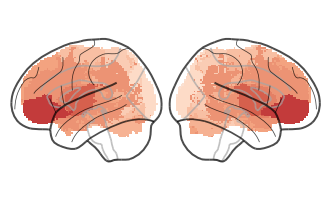

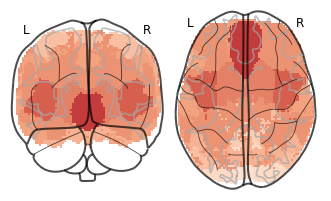

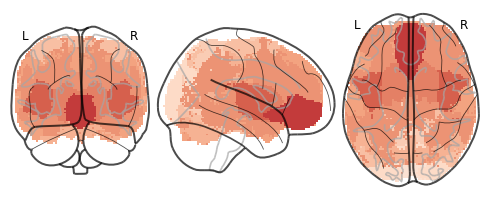

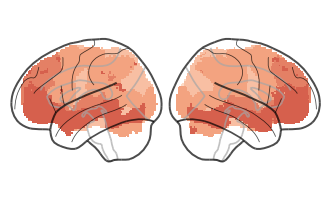

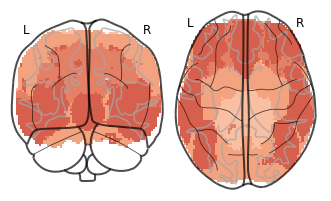

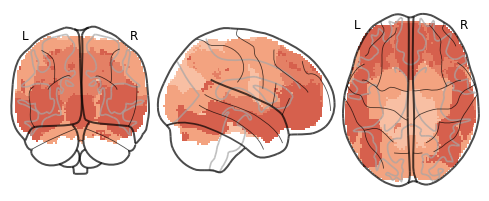

In [10]:
mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

max_time = {'Study1':20, 'Study2':10}
metric = 'median'
study = 'Study1'
for study in ['Study1', 'Study2']:
    params = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Voxel', f'{study}_Autocorrelation_Voxel_ExpFunc_Params_{metric}_ROI.csv'), index_col=0)
    out = time_to_correlation(params, correlation=.1, lags=50)
    dat = roi_to_brain(out, mask_x)

    cmap = 'RdBu_r'
#     max_time = out.max()
    plot_glass_brain(dat.to_nifti(),display_mode='lr',colorbar=False,cmap=cmap,plot_abs=False,vmin=0,vmax=max_time[study])
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_Brain_Lateral_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_Brain_Lateral_Figure.png'), dpi=300)

    plot_glass_brain(dat.to_nifti(),display_mode='yz',colorbar=False,cmap=cmap,plot_abs=False,vmin=0,vmax=max_time[study])
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_Brain_Medial_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_Brain_Medial_Figure.png'), dpi=300)

    plot_glass_brain(dat.to_nifti(),display_mode='ortho',colorbar=False,cmap=cmap,plot_abs=False,vmin=0,vmax=max_time[study])
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_Brain_Ortho_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_Brain_Ortho_Figure.png'), dpi=300)
    print(f'{study} TRs: {out[4]}, {out[32]}')
    

## Test for significant Differences between ROIs on time to 0.1 correlation

In [218]:
for study in ['Study1', 'Study2']:
    for roi in [4, 32]:
        r = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_{metric}.csv'), index_col=0)
        lag = np.arange(0,50)
        sub_params = {}
        for sub in r.columns:
            popt, pcov = curve_fit(exponential_func, lag, r[sub], maxfev=3000)
            sub_params[sub] = np.concatenate([popt, np.sqrt(np.diag(pcov))])
        roi_params = pd.DataFrame(sub_params, index=['a','b','c','a_sd','b_sd','c_sd']).T
        roi_params.to_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Voxel', f'{study}_Autocorrelation_Voxel_ExpFunc_Params_Subject_ROI{roi}.csv'))

for study in ['Study1', 'Study2']:
    out = {}
    for roi in [4,32]:
        dat = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Voxel', f'{study}_Autocorrelation_Voxel_ExpFunc_Params_Subject_ROI{roi}.csv'), index_col=0)
        dat['Subject'] = dat.index
        out[roi] = time_to_correlation(dat, id_column='Subject')
    out = pd.DataFrame(out)
    print(f'\n{study}')
    print(out.describe())
    stats = one_sample_permutation(out[32] - out[4])
    print(f"p = {stats['p']}")



Study1
              4          32
count  13.000000  13.000000
mean    3.615385  18.461538
std     1.192928   6.603224
min     2.000000  12.000000
25%     3.000000  14.000000
50%     3.000000  15.000000
75%     4.000000  22.000000
max     7.000000  30.000000
p = 0.0001999600079984003

Study2
              4          32
count  35.000000  35.000000
mean    3.800000   8.457143
std     1.207818   2.953989
min     2.000000   2.000000
25%     3.000000   6.000000
50%     4.000000   9.000000
75%     4.000000  11.000000
max     8.000000  14.000000
p = 0.0001999600079984003


## Test if there a significant difference between spatial and voxel autocorrelation decay 

In [226]:
for study in ['Study1', 'Study2']:
    for roi in [4,32]:
        spatial = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ExpFunc_Params_Subject_ROI{roi}.csv'), index_col=0)
        spatial['Subject'] = spatial.index
        spatial_time = time_to_correlation(spatial, id_column='Subject')
        voxel = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Voxel', f'{study}_Autocorrelation_Voxel_ExpFunc_Params_Subject_ROI{roi}.csv'), index_col=0)
        voxel['Subject'] = voxel.index
        voxel_time = time_to_correlation(voxel, id_column='Subject')
        combined = pd.concat([spatial_time, voxel_time], axis=1)
        combined.columns = ['Spatial', 'Voxel']
        print(f'\n{study} ROI{roi}')
        print(combined.describe())
        stats = one_sample_permutation(combined['Spatial'] - combined['Voxel'])
        print(f"p = {stats['p']}")



Study1 ROI4
        Spatial      Voxel
count  13.00000  13.000000
mean    4.00000   3.615385
std     1.47196   1.192928
min     3.00000   2.000000
25%     3.00000   3.000000
50%     3.00000   3.000000
75%     5.00000   4.000000
max     8.00000   7.000000
p = 0.129374125174965

Study1 ROI32
         Spatial      Voxel
count  13.000000  13.000000
mean   21.692308  18.461538
std     8.004005   6.603224
min    11.000000  12.000000
25%    16.000000  14.000000
50%    21.000000  15.000000
75%    26.000000  22.000000
max    37.000000  30.000000
p = 0.0033993201359728054

Study2 ROI4
         Spatial      Voxel
count  35.000000  35.000000
mean    4.057143   3.800000
std     1.625945   1.207818
min     2.000000   2.000000
25%     3.000000   3.000000
50%     4.000000   4.000000
75%     4.500000   4.000000
max    10.000000   8.000000
p = 0.07738452309538092

Study2 ROI32
         Spatial      Voxel
count  35.000000  35.000000
mean   10.571429   8.457143
std     4.125143   2.953989
min     3.00000

## Is there a relationship between number of voxels by time

In [207]:

for study in ['Study1', 'Study2']:
    params = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Voxel', f'{study}_Autocorrelation_Voxel_ExpFunc_Params_{metric}_ROI.csv'), index_col=0)
    out = time_to_correlation(params, correlation=.1, lags=50)
    dat = roi_to_brain(out, mask_x)

    d = pd.DataFrame({x:[np.sum(mask_x[x].data),int(out[x])] for x in out},index=['Voxels','Lag']).T
    plt.scatter(d['Voxels'],d['Lag'])
    plt.ylabel('Time Integration',fontsize=18)
    plt.xlabel('ROI Voxels',fontsize=18)
    plt.title(study, fontsize=18)
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation',f'{study}_Voxels_by_Time.png'))
    plt.close()
    print(study, pearsonr(d['Voxels'], d['Lag']))


Study1 (-0.24446790983073854, 0.3996059279071042)
Study2 (0.2832990616450971, 0.42767140843701945)


## Compute timescale for each voxel
Notes:
- ended up running this on the cluster because it was taking so long.

In [ ]:
roi = 32
study = 'Study1'
episode = 'ep01'
delay = 50

for study in ['Study1', 'Study2']:
    for roi in tqdm(range(50)):
        file_list = glob.glob(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_*_Voxel_Autocorrelation_ROI{roi}_delay{delay}.csv'))
        time_scale = {}
        for f in file_list:
            sub = os.path.basename(f).split('_')[1]
            autocorr = pd.read_csv(f, index_col=0)
            autocorr['Lag'] = np.arange(0, 50, 1)
            params = fit_exponential_function(autocorr, maxfev=3000)
            params.rename({'Subject':'Voxel'},axis=1, inplace=True)
            params.to_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_{sub}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_Voxel_Params.csv'))
            time_scale[sub] = time_to_correlation(params, id_column='Voxel')
        time_scale = pd.DataFrame(time_scale)  
        time_scale.to_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_Voxel_Timescale.csv'))


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

Exception ignored in: 'pandas._libs.lib.c_is_list_like'
Traceback (most recent call last):
  File "/Users/lukechang/anaconda3/lib/python3.7/abc.py", line 137, in __instancecheck__
    def __instancecheck__(cls, instance):
KeyboardInterrupt


In [133]:
delay = 50

mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

for metric in ['mean', 'median', 'std']:
    for study in ['Study1', 'Study2']:
        dat = pd.read_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_Voxel_Timescale.csv'), index_col=0)
        n = dat.shape[1]
        autocorr_brain = mask.copy()
        autocorr_brain.data = np.ones((n, len(autocorr_brain.data)))

        for roi in range(50):
            dat = pd.read_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_Voxel_Timescale.csv'), index_col=0)
            autocorr_brain.data[:, mask_x[roi].data == 1] = dat.T.values

        cmap = 'RdBu_r'
        if metric == 'mean':
            max_time = autocorr_brain.mean().data.max()
            min_time = autocorr_brain.mean().data.min()
            plot_glass_brain(autocorr_brain.mean().to_nifti(),display_mode='lr',colorbar=False,cmap=cmap,plot_abs=False,vmin=min_time,vmax=max_time)
            plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_All_Voxels_Brain_Lateral_Figure_{metric}.pdf'))
            plot_glass_brain(autocorr_brain.mean().to_nifti(),display_mode='yz',colorbar=False,cmap=cmap,plot_abs=False,vmin=min_time,vmax=max_time)
            plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_All_Voxels_Brain_Medial_Figure_{metric}.pdf'))

        elif metric == 'median':
            max_time = autocorr_brain.median().data.max()
            min_time = autocorr_brain.median().data.min()
            plot_glass_brain(autocorr_brain.median().to_nifti(),display_mode='lr', colorbar=False,cmap=cmap,plot_abs=False,vmin=min_time,vmax=max_time)
            plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_All_Voxels_Brain_Lateral_Figure_{metric}.pdf'))
            plot_glass_brain(autocorr_brain.median().to_nifti(),display_mode='yz', colorbar=False,cmap=cmap,plot_abs=False,vmin=min_time,vmax=max_time)
            plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_All_Voxels_Brain_Medial_Figure_{metric}.pdf'))
        elif metric == 'std':
            max_time = autocorr_brain.std().data.max()
            min_time = autocorr_brain.std().data.min()
            plot_glass_brain(autocorr_brain.std().to_nifti(),display_mode='lr',colorbar=False,cmap=cmap,plot_abs=False,vmin=min_time,vmax=max_time)
            plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_All_Voxels_Brain_Lateral_Figure_{metric}.pdf'))
            plot_glass_brain(autocorr_brain.std().to_nifti(),display_mode='yz',colorbar=False,cmap=cmap,plot_abs=False,vmin=min_time,vmax=max_time)
            plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_All_Voxels_Brain_Medial_Figure_{metric}.pdf'))


ValueError: shape mismatch: value array of shape (13,1746) could not be broadcast to indexing result of shape (1746,1)

Study1 0.0 35.69230769230769
Study2 0.11428571428571428 26.742857142857144


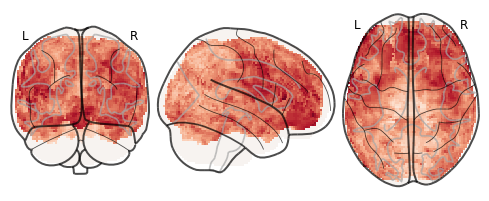

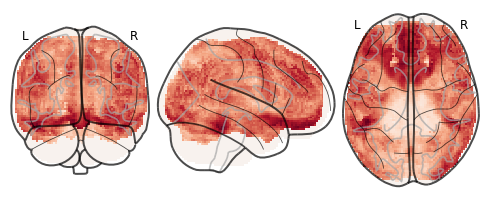

In [136]:
delay = 50

mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

metric = 'mean'
for study in ['Study1', 'Study2']:
    dat = pd.read_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_Voxel_Timescale.csv'), index_col=0)
    n = dat.shape[1]
    autocorr_brain = mask.copy()
    autocorr_brain.data = np.ones((n, len(autocorr_brain.data)))

    for roi in range(50):
        dat = pd.read_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_Voxel_Timescale.csv'), index_col=0)
        autocorr_brain.data[:, mask_x[roi].data == 1] = dat.T.values
    autocorr_brain.write(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel',f'{study}_Voxel_Autocorrelation_WholeBrain.nii.gz'))

    cmap = 'RdBu_r'
    if metric == 'mean':
        max_time = autocorr_brain.mean().data.max()
        min_time = autocorr_brain.mean().data.min()
        print(study, min_time, max_time)
        plot_glass_brain(autocorr_brain.mean().to_nifti(),display_mode='ortho', colorbar=False, cmap=cmap, plot_abs=False, vmin=min_time,vmax=max_time)
        plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_All_Voxels_Brain_Ortho_Figure_{metric}.pdf'))
        plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_All_Voxels_Brain_Ortho_Figure_{metric}.png'), dpi=300)
#         plot_glass_brain(autocorr_brain.mean().to_nifti(),display_mode='lr', colorbar=False, cmap=cmap, plot_abs=False, vmin=min_time,vmax=max_time)
#         plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_All_Voxels_Brain_Lateral_Figure_{metric}.pdf'))
#         plot_glass_brain(autocorr_brain.mean().to_nifti(),display_mode='yz', colorbar=False, cmap=cmap, plot_abs=False, vmin=min_time,vmax=max_time)
#         plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Voxel_Autocorrelation_All_Voxels_Brain_Medial_Figure_{metric}.pdf'))


# Correlation vs Euclidean Distance in vmPFC

## Spatial Autocorrelation

In [114]:
study = 'Study1'
episode = 'ep01'
distance = 'euclidean'

for study in tqdm(['Study1', 'Study2']):
    for roi in [4, 32]:
        file_list = glob.glob(os.path.join(base_dir, 'Data', study, 'Denoised_ROI', f'*{episode}_Denoised_ROI{roi}.csv'))
        for distance in ['correlation','euclidean']:
            autocorr = []
            for f in file_list:
                sub = os.path.basename(f).split('_')[0]
                sdat = pd.read_csv(f)
                d = Adjacency(pairwise_distances(sdat, metric=distance), metric='distance')
                sub_autocorr = []
                for x in range(1,50):
                    sub_autocorr.append(np.diag(d.squareform(), x).mean())
                autocorr.append(sub_autocorr)
            autocorr = pd.DataFrame(autocorr).T
            autocorr['Lag'] = autocorr.index
            autocorr_long = autocorr.melt(id_vars='Lag', var_name='Subject', value_name=distance)
            autocorr_long.to_csv(os.path.join(base_dir, 'Analyses','Spatiotemporal_Autocorrelation',f'{study}_{episode}_Spatial_Autocorrelation_ROI{roi}_{distance}.csv'))



100%|██████████| 2/2 [09:55<00:00, 297.91s/it]


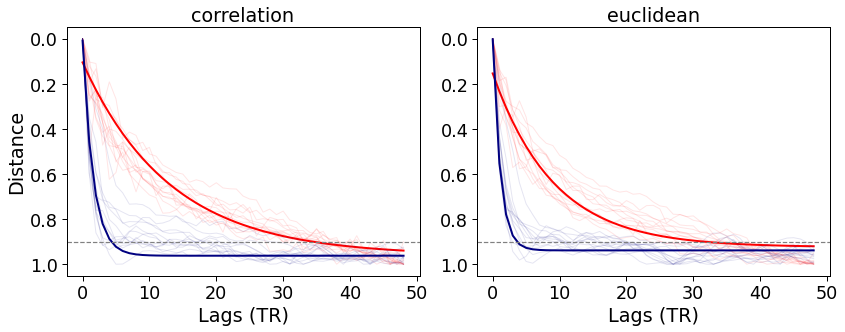

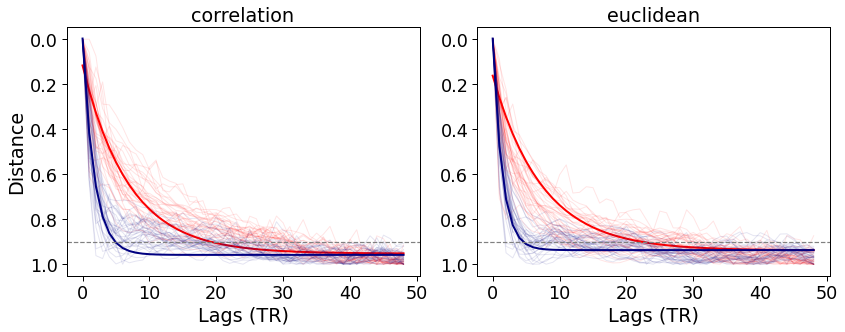

In [174]:
colors = ['red','navy']
scaler = MinMaxScaler(feature_range=(0,1))

with sns.plotting_context(context='paper', font_scale=2):
    for study in ['Study1', 'Study2']:
        f,a = plt.subplots(ncols=2, figsize=(12,5))
        for i,distance in enumerate(['correlation','euclidean']):
            autocorr_v1 = pd.read_csv(os.path.join(base_dir, 'Analyses','Spatiotemporal_Autocorrelation',f'{study}_{episode}_Autocorrelation_ROI4_{distance}.csv'), index_col=0)
            autocorr_vmpfc = pd.read_csv(os.path.join(base_dir, 'Analyses','Spatiotemporal_Autocorrelation',f'{study}_{episode}_Autocorrelation_ROI32_{distance}.csv'), index_col=0)
            autocorr_v1['Region'] = 'V1'
            autocorr_vmpfc['Region'] = 'vmPFC'
            autocorr = pd.concat([autocorr_vmpfc,autocorr_v1], axis=0)

            for j,roi in enumerate(autocorr['Region'].unique()):
                for sub in autocorr['Subject'].unique():
                    a[i].plot(autocorr.query('Subject==@sub&Region==@roi')['Lag'], scaler.fit_transform(autocorr.query('Subject==@sub&Region==@roi')[distance].values.reshape(1,-1).T), color=colors[j], linewidth=1,alpha=.1,linestyle='-')
                autocorr_median = scaler.fit_transform(autocorr.query('Region==@roi').pivot(values=distance, columns='Subject', index='Lag').median(axis=1).values.reshape(-1,1)).flatten()
                lags = autocorr.query('Region==@roi').pivot(values=distance, columns='Subject', index='Lag').index
                popt, pcov = curve_fit(exponential_func, lags, autocorr_median, maxfev=3000)
                a[i].plot(lags, exponential_func(lags, popt[0],popt[1],popt[2]), color=colors[j], linewidth=2)
            a[i].invert_yaxis()
            a[i].set_title(distance)
            a[i].axhline(0.9, color='grey', linestyle='--')
#             a[i].legend(['V1','vmPFC'])
            a[i].set_xlabel('Lags (TR)')
        a[0].set_ylabel('Distance')
        plt.tight_layout()
        plt.savefig(os.path.join(base_dir, 'Figures','Spatiotemporal_Autocorrelation',f'{study}_{episode}_Spatial_Autocorrelation_EuclideanCorrelationDistance.pdf'))
        
        

## Voxel Autocorrelation

In [141]:
episode = 'ep01'
delay = 50

def autocorrelation(data, delay=50, metric='correlation'):
    data = np.array(data)
    out = deepcopy(data)
    for d in range(1, delay + 1):
        out = np.vstack([out, np.concatenate([data[d:], [np.nan]*d])])
    out = out.T
    out = out[:-delay]
    r = np.corrcoef(out.T)
    dist = pairwise_distances(out, metric=metric)
    autocorr = []
    for d in range(1, delay + 1):
        autocorr.append(np.mean(np.diag(dist, k=d)))
    return np.array(autocorr)


for study in tqdm(['Study1', 'Study2']):
    for roi in [4,32]:
        for distance in ['correlation','euclidean']:
            file_list = glob.glob(os.path.join(base_dir, 'Data', study, 'Denoised_ROI', f'*{episode}_Denoised_ROI{roi}.csv'))
            autocorr_all = {}
            for f in file_list:
                sub = os.path.basename(f).split('_')[0]
                data = pd.read_csv(f)
                dat = pd.DataFrame(data.apply(autocorrelation, delay=delay, metric=distance, axis=0))
                dat.to_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_{sub}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_distance_{distance}.csv'))
                autocorr_all[sub] = dat.median(axis=1)
            autocorr_all = pd.DataFrame(autocorr_all)
            autocorr_all.to_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_median_distance_{distance}.csv'))


100%|██████████| 2/2 [6:07:39<00:00, 11029.59s/it] 


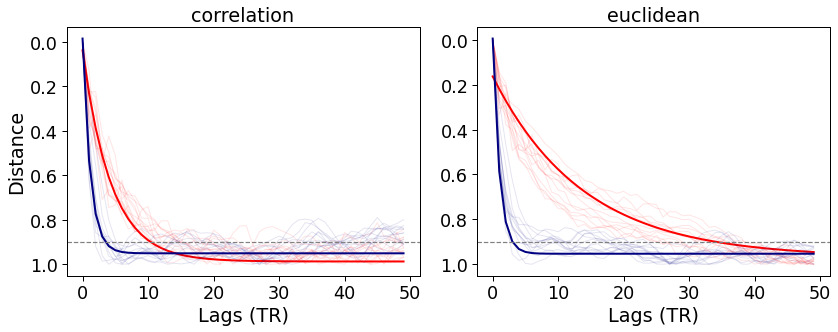

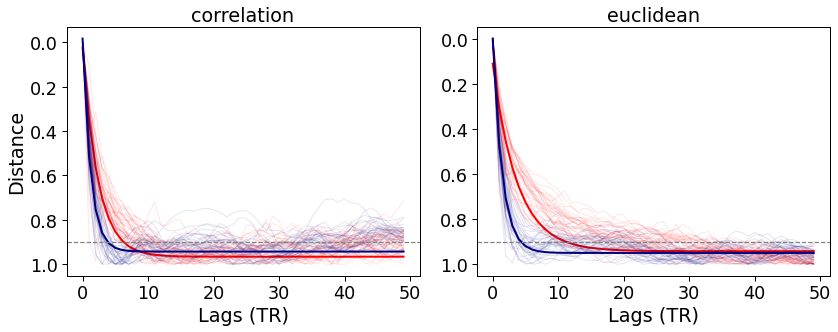

In [175]:
colors = ['red','navy']
scaler = MinMaxScaler(feature_range=(0,1))

with sns.plotting_context(context='paper', font_scale=2):
    for study in ['Study1', 'Study2']:
        f,a = plt.subplots(ncols=2, figsize=(12,5))
        for i,distance in enumerate(['correlation','euclidean']):
            autocorr_v1 = pd.read_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI4_delay{delay}_median_distance_{distance}.csv'), index_col=0)
            autocorr_v1['Lag'] = np.arange(0,delay)
            autocorr_v1= autocorr_v1.melt(id_vars='Lag', var_name='Subject', value_name=distance)
            autocorr_vmpfc = pd.read_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI32_delay{delay}_median_distance_{distance}.csv'), index_col=0)
            autocorr_vmpfc['Lag'] = np.arange(0,delay)
            autocorr_vmpfc= autocorr_vmpfc.melt(id_vars='Lag', var_name='Subject', value_name=distance)
            autocorr_v1['Region'] = 'V1'
            autocorr_vmpfc['Region'] = 'vmPFC'
            autocorr = pd.concat([autocorr_vmpfc,autocorr_v1], axis=0)

            for j,roi in enumerate(autocorr['Region'].unique()):
                for sub in autocorr['Subject'].unique():
                    a[i].plot(autocorr.query('Subject==@sub&Region==@roi')['Lag'], scaler.fit_transform(autocorr.query('Subject==@sub&Region==@roi')[distance].values.reshape(1,-1).T), color=colors[j], linewidth=1,alpha=.1,linestyle='-')
                autocorr_median = scaler.fit_transform(autocorr.query('Region==@roi').pivot(values=distance, columns='Subject', index='Lag').median(axis=1).values.reshape(-1,1)).flatten()
                lags = autocorr.query('Region==@roi').pivot(values=distance, columns='Subject', index='Lag').index
                popt, pcov = curve_fit(exponential_func, lags, autocorr_median, maxfev=3000)
                a[i].plot(lags, exponential_func(lags, popt[0],popt[1],popt[2]), color=colors[j], linewidth=2)
            a[i].invert_yaxis()
            a[i].axhline(0.9, color='grey', linestyle='--')
            a[i].set_title(distance)
#             a[i].legend(['V1','vmPFC'])
            a[i].set_xlabel('Lags (TR)')
        a[0].set_ylabel('Distance')
        plt.tight_layout()
        plt.savefig(os.path.join(base_dir, 'Figures','Spatiotemporal_Autocorrelation',f'{study}_{episode}_Voxel_Autocorrelation_EuclideanCorrelationDistance.pdf'))
        


# PCC Autocorrelation

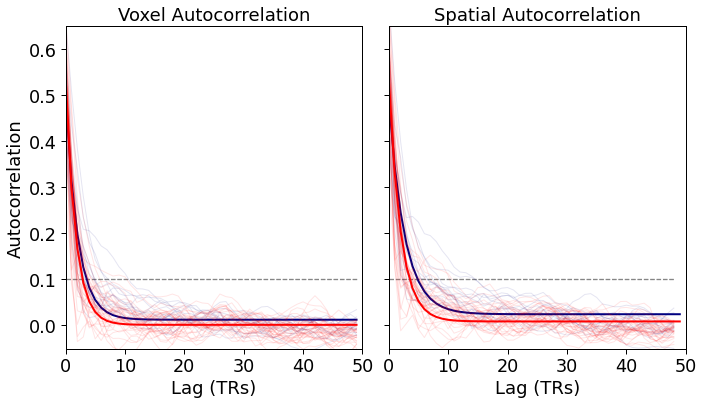

In [29]:
roi= 19
colors = ['navy','red']
metric = 'median'
delay = 50
lag = np.arange(0,50)

with sns.plotting_context(context='paper',font_scale=2):
    f,a = plt.subplots(ncols=2,figsize=(10,6), sharey=True, sharex=True)
    for i,study in enumerate(['Study1', 'Study2']):
    
        # Voxel Autocorrelation
        r = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Voxel', f'{study}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_{metric}.csv'), index_col=0)
        for sub in r: # raw
            a[0].plot(np.arange(0, r.shape[0],1), r[sub], color=colors[i], linewidth=1, alpha=.1, linestyle='-')
        params = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Voxel', f'{study}_Autocorrelation_Voxel_ExpFunc_Params_{metric}_ROI.csv'), index_col=0)
        a[0].plot(np.arange(0, r.shape[0],1), exponential_func(lag, 
                                 params.query('ROI==@roi')['a'].values[0],
                                 params.query('ROI==@roi')['b'].values[0],
                                 params.query('ROI==@roi')['c'].values[0]), color=colors[i], linewidth=2)
        a[0].set_xlabel('Lag (TRs)', fontsize=18)
        a[0].set_ylabel('Autocorrelation', fontsize=18)
        a[0].hlines(.1,xmin=0,xmax=r.shape[0]-1,linestyle='--',color='grey',alpha=.8)
        a[0].set_xlim([0,50])
        a[0].set_ylim([-0.05,.65])
        a[0].set_title(f'Voxel Autocorrelation', fontsize=18)

        # Spatial Autocorrelation
        r = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ROI{roi}.csv'),index_col=0)
        r.drop(columns='Lag', inplace=True)
        for sub in r: # raw
            a[1].plot(np.arange(0,r.shape[0]), r[sub], color=colors[i], linewidth=1, alpha=.1, linestyle='-')
        params = pd.read_csv(os.path.join(base_dir, 'Analyses','Autocorrelation_Spatial', f'{study}_Autocorrelation_Spatial_ExpFunc_Params_Median_ROI.csv'), index_col=0)
        a[1].plot(lag, exponential_func(lag, 
                                 params.query('ROI==@roi')['a'].values[0],
                                 params.query('ROI==@roi')['b'].values[0],
                                 params.query('ROI==@roi')['c'].values[0]), color=colors[i], linewidth=2)
        a[1].set_xlabel('Lag (TRs)', fontsize=18)
        a[1].hlines(.1,xmin=0,xmax=r.shape[0]-1,linestyle='--',color='grey',alpha=.8)
    a[1].set_xlim([0,50])
    a[1].set_ylim([-0.05,.65])
    a[1].set_title(f'Spatial Autocorrelation', fontsize=18)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation',f'SpatialPattern_Autocorrelation_Figure_ROI{roi}.pdf'))
#         plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation',f'SpatialPattern_Autocorrelation_Figure_{study}.png'), dpi=300)


# Test-Retest Reliability of Autocorrelation
 - Ideally, it would be great to look at voxel reliability, however, I'm not sure I sorted the files when I estimated the exponential function.
 - We should go with the episode averages  for now.

In [180]:
study = 'Study1'
metric = 'mean'
delay = 50

mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

for episode in ['ep01', 'ep02']:
    dat = pd.read_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_{episode}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_Voxel_Timescale.csv'), index_col=0)
    n = dat.shape[1]
    autocorr_brain = mask.copy()
    autocorr_brain.data = np.ones((n, len(autocorr_brain.data)))

    for roi in range(50):
        dat = pd.read_csv(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel', f'{study}_{episode}_Voxel_Autocorrelation_ROI{roi}_delay{delay}_Voxel_Timescale.csv'), index_col=0)
        autocorr_brain.data[:, mask_x[roi].data == 1] = dat.T.values
    autocorr_brain.write(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel',f'{study}_{episode}_Voxel_Autocorrelation_WholeBrain.nii.gz'))


In [183]:
roi = 32
ep1 = Brain_Data(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel',f'Study1_ep01_Voxel_Autocorrelation_WholeBrain.nii.gz'))
ep2 = Brain_Data(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel',f'Study1_ep02_Voxel_Autocorrelation_WholeBrain.nii.gz'))

print(f'Avg Whole-Brain Similarity = {ep1.mean().similarity(ep2.mean()):.02}')
print(f'Avg vmPFC Similarity = {ep1.mean().apply_mask(mask_x[roi]).similarity(ep2.mean().apply_mask(mask_x[roi])):.02}')

within_sub_wb_reliability = [x.similarity(y) for x,y in zip(ep1,ep2)]
within_sub_vmpfc_reliability = [x.apply_mask(mask_x[roi]).similarity(y.apply_mask(mask_x[roi])) for x,y in zip(ep1,ep2)]

print(f'Avg Within-Subject Whole-Brain Similarity = {np.mean(within_sub_wb_reliability):.02}')
print(f'Avg Within-Subject vmPFC Similarity = {np.mean(within_sub_vmpfc_reliability):.02}')


Avg Whole-Brain Similarity = 0.91
Avg vmPFC Similarity = 0.88
Avg Within-Subject Whole-Brain Similarity = 0.4
Avg Within-Subject vmPFC Similarity = 0.34


In [191]:
print(pearsonr(ep1.mean().data, ep2.mean().data))
print(pearsonr(ep1.mean().apply_mask(mask_x[roi]).data, ep2.mean().apply_mask(mask_x[roi]).data))

(0.9138485368643353, 0.0)
(0.876060197680459, 0.0)


# Relationship between Voxel Autocorrelation and tSNR
## Load Data

In [192]:
episode = 'ep01'
mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

s1_autocorr = Brain_Data(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel',f'Study1_{episode}_Voxel_Autocorrelation_WholeBrain.nii.gz'))
# s1_autocorr = Brain_Data(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel',f'Study1_Voxel_Autocorrelation_WholeBrain.nii.gz'))
s2_autocorr = Brain_Data(os.path.join(base_dir ,'Analyses', 'Autocorrelation_Voxel',f'Study2_Voxel_Autocorrelation_WholeBrain.nii.gz'))

s1_tsnr = Brain_Data(glob.glob(os.path.join(base_dir,'Analyses', 'tSNR', f'*_Study1_{episode}_tSNR.nii.gz')))
s2_tsnr = Brain_Data(glob.glob(os.path.join(base_dir,'Analyses', 'tSNR', f'*_Study2_{episode}_tSNR.nii.gz')))

## Correlation between autocorrelation and tSNR

In [193]:
roi = 32
print('\nWhole-Brain tSNR Autocorrelation Correlation')
print(f"Study1 Whole-Brain Correlation, r = {s1_autocorr.mean().similarity(s1_tsnr.mean(), method='correlation'):.02}")
print(f"Study2 Whole-Brain Correlation, r = {s2_autocorr.mean().similarity(s2_tsnr.mean(), method='correlation'):.02}")

s1_autocorr_tsnr = [x.similarity(y, method='correlation') for x,y in zip(s1_autocorr.apply_mask(mask_x[roi]), s1_tsnr.apply_mask(mask_x[roi]))]
s2_autocorr_tsnr = [x.similarity(y, method='correlation') for x,y in zip(s2_autocorr.apply_mask(mask_x[roi]), s2_tsnr.apply_mask(mask_x[roi]))]

print('\nvmPFC tSNR Autocorrelation Correlation')
print(f"Study1 vmPFC Correlation, r = {s1_autocorr.mean().apply_mask(mask_x[roi]).similarity(s1_tsnr.mean().apply_mask(mask_x[roi]), method='correlation'):.02}")
print(f"Study2 vmPFC Correlation, r = {s2_autocorr.mean().apply_mask(mask_x[roi]).similarity(s2_tsnr.mean().apply_mask(mask_x[roi]), method='correlation'):.02}")
print(f"Study1 vmPFC Within-Subject Correlation, r = {np.mean(s1_autocorr_tsnr):.02}")
print(f"Study2 vmPFC Within-Subject Correlation, r = {np.mean(s2_autocorr_tsnr):.02}")

print('\nStudy1/Study2 Autocorrelation Correlation')
print(f"Study1/Study2 Whole-Brain Correlation, r = {s1_autocorr.mean().similarity(s2_autocorr.mean(), method='correlation'):.02}")
print(f"Study1/Study2 vmPFC Correlation, r = {s1_autocorr.mean().apply_mask(mask_x[roi]).similarity(s2_autocorr.mean().apply_mask(mask_x[roi]), method='correlation'):.02}")

print('\nStudy1/Study2 TSNR correlation')
print(f"Study1/Study2 Whole-Brain Correlation, r = {s1_tsnr.mean().similarity(s2_tsnr.mean(), method='correlation'):.02}")
print(f"Study1/Study2 vmPFC Correlation, r = {s1_tsnr.mean().apply_mask(mask_x[roi]).similarity(s2_tsnr.mean().apply_mask(mask_x[roi]), method='correlation'):.02}")



Whole-Brain tSNR Autocorrelation Correlation
Study1 Whole-Brain Correlation, r = 0.095
Study2 Whole-Brain Correlation, r = -0.12

vmPFC tSNR Autocorrelation Correlation
Study1 vmPFC Correlation, r = -0.72
Study2 vmPFC Correlation, r = -0.71
Study1 vmPFC Within-Subject Correlation, r = -0.35
Study2 vmPFC Within-Subject Correlation, r = -0.35

Study1/Study2 Autocorrelation Correlation
Study1/Study2 Whole-Brain Correlation, r = 0.72
Study1/Study2 vmPFC Correlation, r = 0.55

Study1/Study2 TSNR correlation
Study1/Study2 Whole-Brain Correlation, r = 0.7
Study1/Study2 vmPFC Correlation, r = 0.78


In [196]:
print(pearsonr(s1_autocorr.mean().data, s2_autocorr.mean().data))
print(pearsonr(s1_autocorr.mean().apply_mask(mask_x[roi]).data, s2_autocorr.mean().apply_mask(mask_x[roi]).data))

print(pearsonr(s1_autocorr.mean().apply_mask(mask_x[roi]).data, s1_tsnr.mean().apply_mask(mask_x[roi]).data))
print(pearsonr(s2_autocorr.mean().apply_mask(mask_x[roi]).data, s2_tsnr.mean().apply_mask(mask_x[roi]).data))


(0.7195440099707079, 0.0)
(0.5542331853439781, 2.399206835407355e-288)
(-0.7220520542727057, 0.0)
(-0.7051478239117983, 0.0)


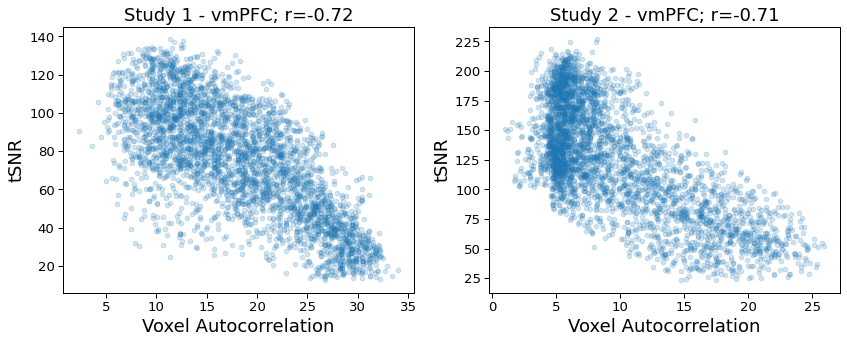

In [180]:
with sns.plotting_context(context='paper', font_scale=1.5):
    f,a = plt.subplots(ncols=2, figsize = (12, 5))
    a[0].scatter(s1_autocorr.mean().apply_mask(mask_x[roi]).data, s1_tsnr.mean().apply_mask(mask_x[roi]).data, alpha=.2)
    a[0].set_ylabel('tSNR', fontsize=18)
    a[0].set_xlabel('Voxel Autocorrelation', fontsize=18)
    a[0].set_title(f'Study 1 - vmPFC; r={pearsonr(s1_autocorr.mean().apply_mask(mask_x[roi]).data, s1_tsnr.mean().apply_mask(mask_x[roi]).data)[0]:.02}', fontsize=18)
    a[1].scatter(s2_autocorr.mean().apply_mask(mask_x[roi]).data, s2_tsnr.mean().apply_mask(mask_x[roi]).data, alpha=.2)
    a[1].set_ylabel('tSNR', fontsize=18)
    a[1].set_xlabel('Voxel Autocorrelation', fontsize=18)
    a[1].set_title(f'Study 2 - vmPFC; r={pearsonr(s2_autocorr.mean().apply_mask(mask_x[roi]).data, s2_tsnr.mean().apply_mask(mask_x[roi]).data)[0]:.02}', fontsize=18)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir,'Figures', 'Autocorrelation', f'vmPFC_Autocorrelation_tSNR_Scatterplot.pdf'))

## Correlation between S1 and S2 Autocorrelation regressing out tSNR

In [197]:
X = np.vstack([np.ones(len(s1_tsnr.mean().data)), s1_tsnr.mean().data]).T
b,t,p,df,res = regress(X, s1_autocorr.mean().data)
s1_autocorr_resid = s1_autocorr.mean().copy()
s1_autocorr_resid.data = res

X = np.vstack([np.ones(len(s2_tsnr.mean().data)), s2_tsnr.mean().data]).T
b,t,p,df,res = regress(X, s2_autocorr.mean().data)
s2_autocorr_resid = s2_autocorr.mean().copy()
s2_autocorr_resid.data = res

print('\nStudy1/Study2 Autocorrelation correlation')
print(f"Study1/Study2 Whole-Brain Correlation, r = {s1_autocorr.mean().similarity(s2_autocorr.mean(), method='correlation')}")
print(f"Study1/Study2 vmPFC Correlation, r = {s1_autocorr.mean().apply_mask(mask_x[roi]).similarity(s2_autocorr.mean().apply_mask(mask_x[roi]), method='correlation')}")

print('\nStudy1/Study2 Autocorrelation correlation - conditioning on tSNR')
print(f"Study1/Study2 Whole-Brain Correlation, r = {s1_autocorr_resid.similarity(s2_autocorr_resid, method='correlation')}")
print(f"Study1/Study2 vmPFC Correlation, r = {s1_autocorr_resid.apply_mask(mask_x[roi]).similarity(s2_autocorr_resid.apply_mask(mask_x[roi]), method='correlation')}")



Study1/Study2 Autocorrelation correlation
Study1/Study2 Whole-Brain Correlation, r = 0.7195440099707071
Study1/Study2 vmPFC Correlation, r = 0.5542331853439781

Study1/Study2 Autocorrelation correlation - conditioning on tSNR
Study1/Study2 Whole-Brain Correlation, r = 0.7323811962829782
Study1/Study2 vmPFC Correlation, r = 0.5781800522376457


In [199]:
print(pearsonr(s1_autocorr.mean().apply_mask(mask_x[roi]).data, s2_autocorr.mean().apply_mask(mask_x[roi]).data))
print(pearsonr(s1_autocorr_resid.apply_mask(mask_x[roi]).data, s2_autocorr_resid.apply_mask(mask_x[roi]).data))


(0.5542331853439781, 2.399206835407355e-288)
(0.5781800522376457, 1.7565e-319)


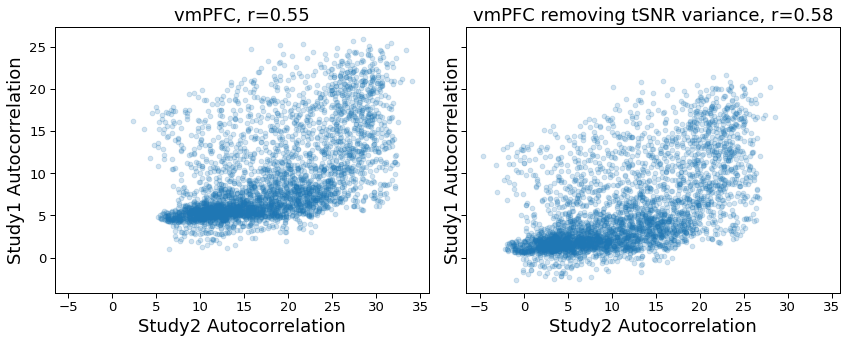

In [227]:
with sns.plotting_context(context='paper', font_scale=1.5):
    f,a = plt.subplots(ncols=2, figsize = (12, 5), sharex=True, sharey=True)
    a[0].scatter(s1_autocorr.mean().apply_mask(mask_x[roi]).data, s2_autocorr.mean().apply_mask(mask_x[roi]).data, alpha=.2)
    a[0].set_ylabel('Study1 Autocorrelation', fontsize=18)
    a[0].set_xlabel('Study2 Autocorrelation', fontsize=18)
    a[0].set_title(f"vmPFC, r={s1_autocorr.mean().apply_mask(mask_x[roi]).similarity(s2_autocorr.mean().apply_mask(mask_x[roi]), method='correlation'):.02}", fontsize=18)

    a[1].scatter(s1_autocorr_resid.apply_mask(mask_x[roi]).data, s2_autocorr_resid.apply_mask(mask_x[roi]).data, alpha=.2)
    a[1].set_ylabel('Study1 Autocorrelation', fontsize=18)
    a[1].set_xlabel('Study2 Autocorrelation', fontsize=18)
    a[1].set_title(f"vmPFC removing tSNR variance, r={s1_autocorr_resid.apply_mask(mask_x[roi]).similarity(s2_autocorr_resid.apply_mask(mask_x[roi]), method='correlation'):.02}", fontsize=18)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir,'Figures', 'Autocorrelation', f'vmPFC_Autocorrelation_Study1Study2_Scatterplot.pdf'))